 14%|█▍        | 286/2000 [04:14<18:57,  1.51it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [26:20<00:00,  1.27it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.0834 - loss: 3.6608 - val_accuracy: 0.0075 - val_loss: 3.9426
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2505 - loss: 2.7351 - val_accuracy: 0.0800 - val_loss: 3.6516
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2991 - loss: 2.4086 - val_accuracy: 0.0950 - val_loss: 3.4133
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4002 - loss: 2.0971 - val_accuracy: 0.0950 - val_loss: 3.4338
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4478 - loss: 1.8639 - val_accuracy: 0.1925 - val_loss: 3.0011
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.4624 - loss: 1.7390 - val_accuracy: 0.1875 - val_loss: 2.9379
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5063 - loss: 1.5965 - val_accuracy: 0.1425 - val_loss: 3.3362
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5587 - loss: 1.4410 - val_accuracy: 0.2450 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


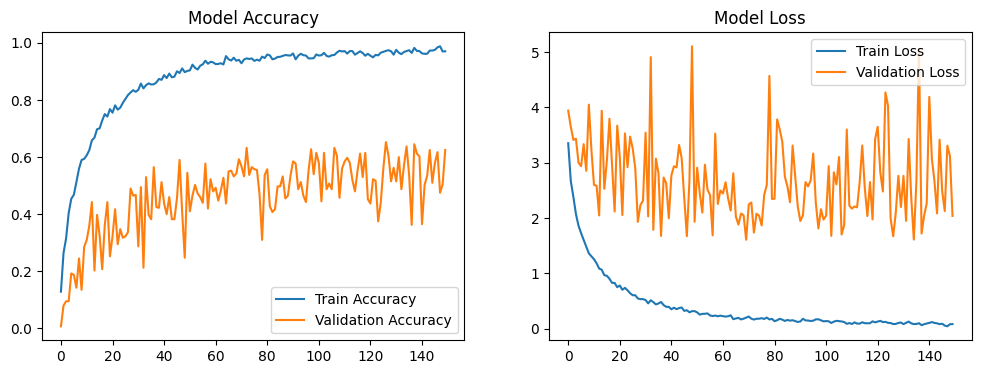

ESC-50 model saved successfully!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < sr * 0.1:
            print(f"Skipping short audio file: {file_path}")
            return None

        # Extract Log-Mel Spectrogram (LM)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Extract Tonnetz (TZ)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        def resize_feature(feature, target_size):
            return np.pad(feature, ((0, max(0, target_size[0] - feature.shape[0])),
                                     (0, max(0, target_size[1] - feature.shape[1]))), mode='constant')

        mel_spec = resize_feature(mel_spec, target_size)
        tonnetz = resize_feature(tonnetz, target_size)

        stacked_features = np.stack([mel_spec, tonnetz], axis=-1)
        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

if len(X) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

X = np.array(X)
y = to_categorical(y, num_classes=50)
X_resized = np.array([tf.image.resize(img, (128, 128)).numpy() for img in X])
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

class ESC50ModelTrainer:
    def __init__(self, input_shape=(128, 128, 2), num_classes=50):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1024))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dense(self.num_classes, activation='softmax'))
        return model

    def compile_model(self):
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

trainer = ESC50ModelTrainer()
trainer.compile_model()
model = trainer.model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Extract Training and Validation Accuracy
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

# Evaluate Model on Test Set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute Metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print Metrics
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


# Save the trained model
model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_LM+TZ_esc50_model.h5")
print("ESC-50 model saved successfully!")


In [ ]:
# Evaluate model on training and test data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9494
Validation Accuracy: 0.6250


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load pre-trained ESC-50 model
CNN2_LM_TZ_esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_LM_TZ_esc50_model.h5"
base_model = load_model(CNN2_LM_TZ_esc50_model_path)

# Define new input layer to properly wrap the pre-trained model
input_layer = Input(shape=(128, 128, 2))
x = base_model(input_layer, training=False)  # Pass input through pre-trained model
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(10, activation='softmax')(x)  # UrbanSound8K has 10 classes

# Properly setting the model
urban_model = Model(inputs=base_model.input, outputs=out)
urban_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Process UrbanSound8K dataset
urbansound_csv = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

urbansound_metadata = pd.read_csv(urbansound_csv)

# ------------------- Fix: Feature Extraction (Ensure Shapes Match) -------------------

def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        # **Check if the signal is too short (Avoid Librosa warnings)**
        if len(y) < 512:  # Skip if the signal is too short
            print(f"Skipping very short audio file: {file_path} (length={len(y)})")
            return None

        # **Dynamically adjust `n_fft` based on signal length**
        n_fft = min(512, len(y) // 2)  # Ensure `n_fft` is always <= half the signal
        hop_length = max(128, n_fft // 4)  # Dynamically adjust hop_length

        # **Compute Log-Mel Spectrogram (LM)**
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # **Compute Tonnetz (TZ) - Skip if the signal is too short**
        if len(y) >= 2048:  # Compute Tonnetz only if the signal is long enough
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        else:
            tonnetz = np.zeros((6, mel_spec.shape[1]))  # Use zero matrix if no harmonic content

        # **Ensure Tonnetz has the same time dimension as Mel Spectrogram**
        tonnetz_resized = np.pad(tonnetz, ((0, max(0, 128 - tonnetz.shape[0])),
                                           (0, max(0, mel_spec.shape[1] - tonnetz.shape[1]))),
                                 mode='constant')

        # **Resize both to (128, 128)**
        def resize_feature(feature, target_size):
            return tf.image.resize(np.expand_dims(feature, axis=-1), target_size).numpy().squeeze()

        mel_spec = resize_feature(mel_spec, target_size)
        tonnetz_resized = resize_feature(tonnetz_resized, target_size)

        # **Ensure shapes match before stacking**
        if mel_spec.shape != tonnetz_resized.shape:
            print(f"Skipping due to shape mismatch: Mel: {mel_spec.shape}, Tonnetz: {tonnetz_resized.shape}")
            return None

        # **Stack features (LM + TZ)**
        stacked_features = np.stack([mel_spec, tonnetz_resized], axis=-1)

        # **Ensure final shape consistency**
        if stacked_features.shape != (128, 128, 2):
            print(f"Skipping due to inconsistent shape: {stacked_features.shape} for file {file_path}")
            return None

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


# ------------------- Process UrbanSound8K Audio Files -------------------

X_urban, y_urban = [], []
print("Processing UrbanSound8K dataset...")

for _, row in tqdm(urbansound_metadata.iterrows(), total=len(urbansound_metadata)):
    file_path = os.path.join(urbansound_audio_dir, f"fold{row['fold']}", row['slice_file_name'])
    label = row['classID']

    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue

    features = extract_features(file_path)

    if features is not None:
        X_urban.append(features)
        y_urban.append(label)

if len(X_urban) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

# Convert to NumPy arrays safely
X_urban = np.asarray(X_urban)
y_urban = to_categorical(y_urban, num_classes=10)

print(f"Dataset successfully processed! {X_urban.shape[0]} samples available.")

# Ensure dataset splitting happens correctly
if len(X_urban) > 0:
    X_train_urban, X_test_urban, y_train_urban, y_test_urban = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)
    print(f"Training set: {X_train_urban.shape}, Test set: {X_test_urban.shape}")

# Fine-tune on UrbanSound8K
history_urban = urban_model.fit(X_train_urban, y_train_urban, epochs=50, batch_size=32, validation_data=(X_test_urban, y_test_urban))

# Save the fine-tuned model
urban_model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/urbansound8k_cnn_model.h5")
print("Fine-tuned UrbanSound8K model saved successfully!")


Processing UrbanSound8K dataset...


  0%|          | 0/8732 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
  0%|          | 9/8732 [00:50<3:27:36,  1.43s/it]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=4

Dataset successfully processed! 8732 samples available.
Training set: (6985, 128, 128, 2), Test set: (1747, 128, 128, 2)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 216s 956ms/step - accuracy: 0.2230 - loss: 2.2606 - val_accuracy: 0.4665 - val_loss: 2.1183
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 205s 936ms/step - accuracy: 0.4999 - loss: 1.5475 - val_accuracy: 0.5644 - val_loss: 1.6783
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 266s 950ms/step - accuracy: 0.5939 - loss: 1.3052 - val_accuracy: 0.6285 - val_loss: 1.2103
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 207s 946ms/step - accuracy: 0.6283 - loss: 1.1938 - val_accuracy: 0.6251 - val_loss: 1.1605
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 265s 959ms/step - accuracy: 0.6755 - loss: 1.0584 - val_accuracy: 0.6611 - val_loss: 1.0541
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 256s 933ms/step - accuracy: 0.6718 - loss: 1.0743 - val_accuracy: 0.6669 - val_loss: 1.0593
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 263s 938ms/step - accuracy: 0.7066 - loss: 0.99

Fine-tuned UrbanSound8K model saved successfully!


In [ ]:
# Evaluate model on training data
train_loss, train_accuracy = urban_model.evaluate(X_train_urban, y_train_urban, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on test data
test_loss, test_accuracy = urban_model.evaluate(X_test_urban, y_test_urban, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = urban_model.predict(X_test_urban)  # Get probability outputs
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_classes = np.argmax(y_test_urban, axis=1)  # Convert one-hot encoded labels to class labels


from sklearn.metrics import precision_score, recall_score, f1_score


# Compute precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Ensure the import is available
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Debugging step: Check class labels before computing classification report
print("y_true_classes:", type(y_true_classes), y_true_classes.shape)
print("y_pred_classes:", type(y_pred_classes), y_pred_classes.shape)

# Compute classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)])

print("\nClassification Report:\n")
print(report)
print(f"Final Test Accuracy (from classification report): {accuracy_score(y_true_classes, y_pred_classes):.4f}")



Training Accuracy: 0.8939
Test Accuracy: 0.8517
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step
Precision: 0.8543
Recall: 0.8517
F1 Score: 0.8498
y_true_classes: <class 'numpy.ndarray'> (1747,)
y_pred_classes: <class 'numpy.ndarray'> (1747,)

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       203
           1       0.89      0.83      0.86        86
           2       0.84      0.67      0.75       183
           3       0.86      0.84      0.85       201
           4       0.84      0.89      0.86       206
           5       0.84      0.91      0.87       193
           6       0.92      0.97      0.95        72
           7       0.93      0.93      0.93       208
           8       0.84      0.91      0.87       165
           9       0.87      0.73      0.79       230

    accuracy                           0.85      1747
   macro avg       0.86      0.86      0.86      1747
weighted avg       0.85      0.85  

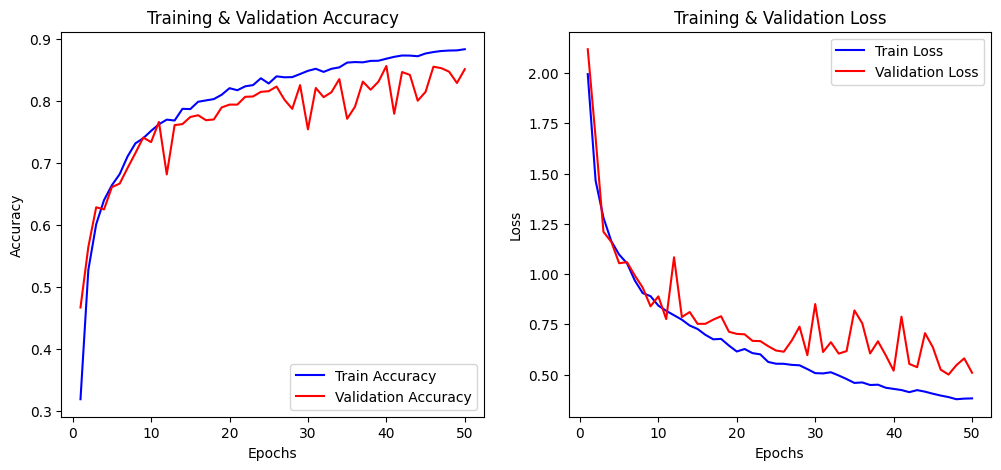

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    """
    Plots Training & Validation Accuracy and Loss from the history object.
    :param history: Keras history object from model training
    """
    # Extracting values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Number of epochs

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_results(history_urban)


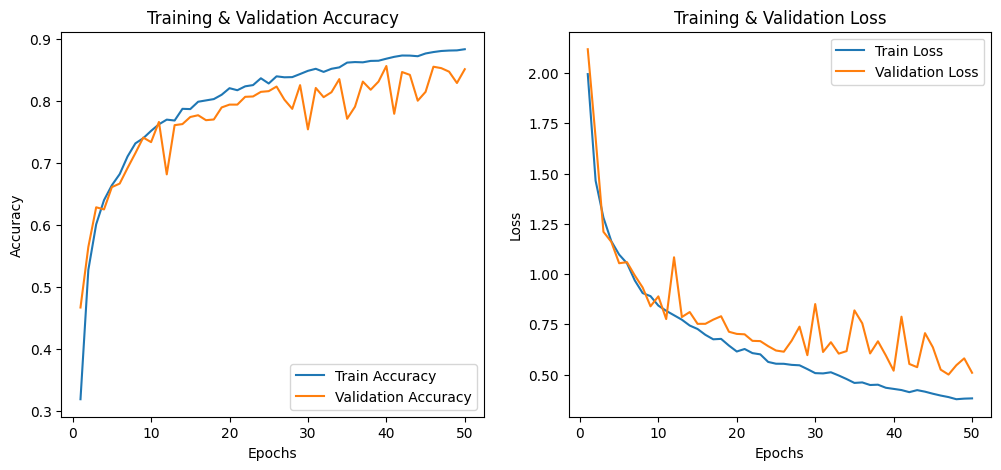

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    """
    Plots Training & Validation Accuracy and Loss from the history object.
    :param history: Keras history object from model training
    """
    # Extracting values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Number of epochs

    # Define colors
    train_color = 'tab:blue'  # Blue for Train Accuracy & Loss
    val_color = 'tab:orange'  # Orange for Validation Accuracy & Loss

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color=train_color, label='Train Accuracy')
    plt.plot(epochs, val_acc, color=val_color, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color=train_color, label='Train Loss')
    plt.plot(epochs, val_loss, color=val_color, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_results(history_urban)


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

# ====================================================
# Feature Extraction Function: Log-Mel + Tonnetz (TZ)
# ====================================================
def extract_features(file_path, sr=22050, n_mels=128, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)
        if len(y) < 512:
            print(f"Skipping short file: {file_path}")
            return None

        # === Log-Mel Spectrogram ===
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[1], axis=1)
        mel_spec = librosa.util.fix_length(mel_spec, size=target_size[0], axis=0)

        # === Tonnetz ===
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(chroma=chroma, sr=sr)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[1], axis=1)
        tonnetz = librosa.util.fix_length(tonnetz, size=target_size[0], axis=0)

        # Stack features
        mel_spec = np.expand_dims(mel_spec, axis=-1)
        tonnetz = np.expand_dims(tonnetz, axis=-1)
        combined = np.concatenate([mel_spec, tonnetz], axis=-1)

        if combined.shape != (128, 128, 2):
            print(f"Skipping due to unexpected shape: {combined.shape}")
            return None

        return combined

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ====================================================
# Load Pre-trained ESC-50 Model (Sequential)
# ====================================================
esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_LM_TZ_esc50_model.h5"
old_model = load_model(esc50_model_path)
print("Pre-trained ESC-50 model loaded successfully!")

# ====================================================
# Rebuild Sequential model without last layer
# ====================================================
model = Sequential()
for layer in old_model.layers[:-1]:  # Exclude last layer
    model.add(layer)

# Add new output layer for UrbanSound8K
model.add(tf.keras.layers.Dense(10, activation='softmax', name="urban_output"))

# ====================================================
# Load UrbanSound8K Metadata
# ====================================================
urbansound_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"
metadata = pd.read_csv(urbansound_csv_path)

# ====================================================
# Feature Extraction for UrbanSound8K
# ====================================================
X, y = [], []
for i in tqdm(range(len(metadata))):
    file_name = metadata.loc[i, "slice_file_name"]
    folder = f"fold{metadata.loc[i, 'fold']}"
    file_path = os.path.join(urbansound_audio_dir, folder, file_name)
    label = metadata.loc[i, "classID"]

    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = to_categorical(y, num_classes=10)

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

# ====================================================
# Train-Test Split
# ====================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====================================================
# Compile and Fine-tune the Model
# ====================================================
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# ====================================================
# Evaluate Model
# ====================================================
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# ====================================================
# Classification Report
# ====================================================
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", report)

# ====================================================
# Save Fine-tuned Model
# ====================================================
urbansound_model_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/CNN2_LM_TZ_ESC50_UrbanSound8K.h5"
model.save(urbansound_model_path)
print("Fine-tuned UrbanSound8K model saved successfully!")

# ====================================================
# Save Training History as .npy
# ====================================================
result_path = "/content/drive/MyDrive/Colab Notebooks/Models/Result"
np.save(os.path.join(result_path, "cnn2_LM_TZ_train_acc.npy"), history.history['accuracy'])
np.save(os.path.join(result_path, "cnn2_LM_TZ_val_acc.npy"), history.history['val_accuracy'])
np.save(os.path.join(result_path, "cnn2_LM_TZ_train_loss.npy"), history.history['loss'])
np.save(os.path.join(result_path, "cnn2_LM_TZ_val_loss.npy"), history.history['val_loss'])

print("CNN1 training history saved!")


Pre-trained ESC-50 model loaded successfully!


  0%|          | 0/8732 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
  0%|          | 9/8732 [00:30<2:28:29,  1.02s/it]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=4

Feature shape: (8732, 128, 128, 2), Labels shape: (8732, 10)
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 221s 977ms/step - accuracy: 0.3213 - loss: 1.9665 - val_accuracy: 0.5764 - val_loss: 1.1771
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 259s 967ms/step - accuracy: 0.6731 - loss: 0.9868 - val_accuracy: 0.6674 - val_loss: 0.9722
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7316 - loss: 0.8252 - val_accuracy: 0.7115 - val_loss: 0.8496
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 256s 975ms/step - accuracy: 0.7613 - loss: 0.7277 - val_accuracy: 0.6869 - val_loss: 0.8984
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7926 - loss: 0.6628 - val_accuracy: 0.7562 - val_loss: 0.7377
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.8002 - loss: 0.6207 - val_accuracy: 0.7172 - val_loss: 0.8029
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8200 - loss: 0.5809 - val_accuracy: 0.7350 - val_loss: 0.7953
Epoch 8/50
219/219 ━━━━━━━━

Classification Report:
               precision    recall  f1-score   support

           0     0.8289    0.9310    0.8770       203
           1     0.9692    0.7326    0.8344        86
           2     0.8970    0.8087    0.8506       183
           3     0.9810    0.7711    0.8635       201
           4     0.8493    0.9029    0.8753       206
           5     0.7291    0.9482    0.8243       193
           6     0.9242    0.8472    0.8841        72
           7     0.8978    0.9712    0.9330       208
           8     0.9726    0.8606    0.9132       165
           9     0.9018    0.8783    0.8899       230

    accuracy                         0.8764      1747
   macro avg     0.8951    0.8652    0.8745      1747
weighted avg     0.8871    0.8764    0.8766      1747

Fine-tuned UrbanSound8K model saved successfully!
CNN1 training history saved!


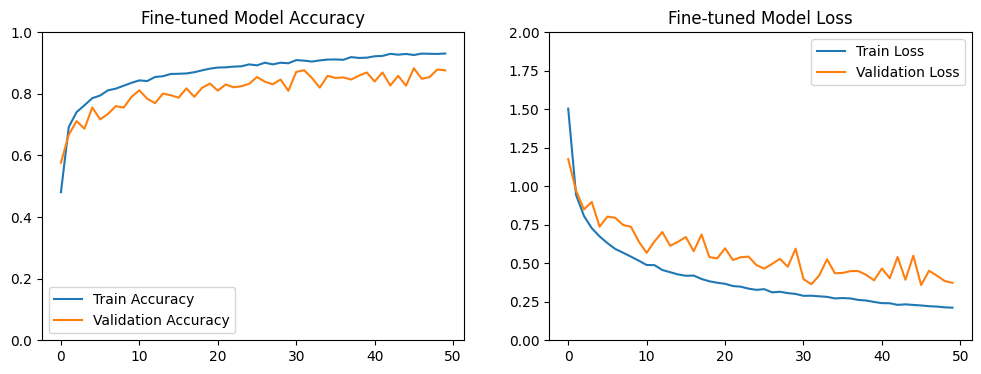

CNN2 training history saved!


In [ ]:
# Plot training history with customized y-axis ranges
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0, 1)  # Set y-axis range for accuracy
plt.legend()
plt.title('Fine-tuned Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim(0, 2)  # Set y-axis range for loss
plt.legend()
plt.title('Fine-tuned Model Loss')

plt.show()


# SAVE CNN1 HISTORY AFTER TRAINING
import numpy as np

np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_TZ_train_acc.npy", history.history['accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_TZ_val_acc.npy", history.history['val_accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_TZ_train_loss.npy", history.history['loss'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_TZ_val_loss.npy", history.history['val_loss'])

print("CNN2 training history saved!")